In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pprint

import clu.checkpoint
import jax
import jax.numpy as jnp
import tensorflow as tf
import sqlalchemy as sa
import seaborn as sns
sns.set_style('whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

from userdiffusion import samplers, unet
from userfm import cs, datasets, diffusion, sde_diffusion, utils

2025-01-08 00:07:45.777248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736294865.795586    5884 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736294865.801401    5884 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/root/workspace/GitHub/pmlr-v202-finzi23a/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# somehow, this line of code prevents a segmentation fault in nn.Dense
# when calling model.init
tf.config.experimental.set_visible_devices([], 'GPU')

In [4]:
# Diffusion Models
# config_alt_id = ''  # c = 4
# config_alt_id = ''  # c = 8
# config_alt_id = ''  # c = 16
# config_alt_id = ''  # c = 32
config_alt_id = '7mrrtp48'  # c = 64

# Flow Matching
# config_alt_id = ''  # c = 4
# config_alt_id = ''  # c = 8
# config_alt_id = ''  # c = 16
# config_alt_id = ''  # c = 32
# config_alt_id = 'ul18oneq'  # c = 64

In [5]:
engine = cs.get_engine()
cs.create_all(engine)
with cs.orm.Session(engine) as session:
    cfg = session.execute(sa.select(cs.Config).where(cs.Config.alt_id == config_alt_id)).first()[0]
    pprint.pp(cfg)

    key = jax.random.key(cfg.rng_seed)
    key, key_dataset = jax.random.split(key)
    
    ds = datasets.get_dataset(cfg.dataset, key=key_dataset)

    cfg_unet = unet.unet_64_config(
        ds.Zs.shape[-1],
        base_channels=cfg.model.architecture.base_channel_count,
        attention=cfg.model.architecture.attention,
    )
    model = unet.UNet(cfg_unet)
    # just create params, restore saved weights later
    params = model.init(
        jax.random.key(0),
        x=ds.Zs[:cfg.dataset.batch_size],
        t=jnp.zeros(cfg.dataset.batch_size),
        train=False,
        cond=None,
    )
    ckpt = clu.checkpoint.MultihostCheckpoint(str(cfg.run_dir/'model-checkpoints'), {}, max_to_keep=2)
    ema_params = ckpt.restore(params)

Config(root_dir='/root/workspace/GitHub/pmlr-v202-finzi23a',
       src_dir='/root/workspace/GitHub/pmlr-v202-finzi23a/userdiffusion/src',
       out_dir='/root/workspace/out/diffusion-dynamics/pmlr-v202-finzi23a',
       prediction_filename='prediction.pt',
       device='cuda',
       id=1,
       alt_id='7mrrtp48',
       rng_seed=42,
       fit=True,
       predict=False,
       model=ModelDiffusion(id=1,
                            architecture=UNet(id=1,
                                              epochs=10000,
                                              learning_rate=0.0001,
                                              base_channel_count=32,
                                              attention=False),
                            sde_diffusion=SDEVarianceExploding(id=1,
                                                               time_min=0.001,
                                                               time_max=1.0,
                                                 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:32<00:00, 13.85it/s]


In [6]:
data_std = ds.Zs[cfg.dataset.batch_size:].std()
data_std

Array(0.7025264, dtype=float32)

In [7]:
def constraint(x):
    fourier_magnitudes = jnp.abs(jnp.fft.rfft(x[..., 0], axis=-1))
    return -(fourier_magnitudes[..., 1:].mean(-1) - .6)

In [8]:
@jax.jit
def score(x, t, cond=None):
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return diffusion.score(model, ema_params, difftype, data_std, x, t, train=False, cond=cond)

In [9]:
@jax.jit
def velocity(x, t, cond=None):
    if not hasattr(t, 'shape') or not t.shape:
        t = jnp.ones(x.shape[0]) * t
    return -model.apply(ema_params, x=x, t=t, train=False, cond=cond)

In [10]:
trajectory_count = cfg.dataset.batch_size
key, key_samples = jax.random.split(key)
if isinstance(cfg.model, cs.ModelDiffusion):
    difftype = sde_diffusion.get_sde_diffusion(cfg.model.sde_diffusion)
    event_scores = samplers.event_scores(difftype, score, constraint, reg=1e-3)
    key_samples, key_event_samples = jax.random.split(key_samples)
    event_samples = samplers.sde_sample(difftype, event_scores, key_event_samples, ds.Zs[:trajectory_count].shape, nsteps=1_000)
    samples = samplers.sde_sample(difftype, score, key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000)
elif isinstance(cfg.model, cs.ModelFlowMatching):
    samples = samplers.ode_sample_taos(velocity, 1., key_samples, x_shape=ds.Zs[:trajectory_count].shape, nsteps=1_000)
else:
    raise ValueError(f'Unknown model: {cfg.model}')

Model-sampled events


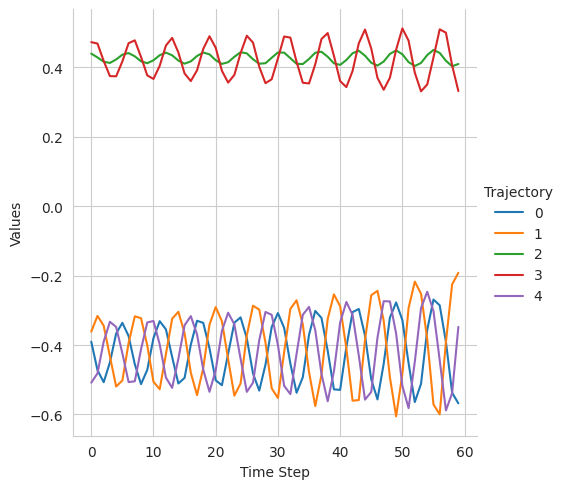

In [11]:
trajectory_count = 5
df = pd.concat([
    pd.DataFrame(dict(Values=samples[constraint(samples) > 0][i, :, 0]))
    for i in range(trajectory_count)
], axis=0, keys=map(str, range(trajectory_count))).reset_index(names=['Trajectory', 'Time Step'])
sns.relplot(
    kind='line',
    data=df,
    x='Time Step', y='Values',
    hue='Trajectory',
)
print('Model-sampled events')

Data


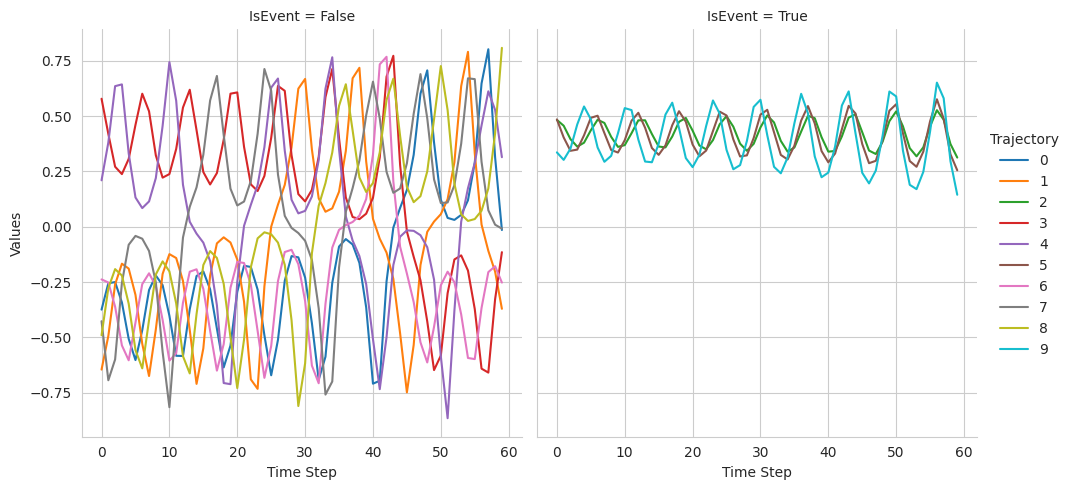

In [12]:
trajectory_count = 10
df = pd.concat([
    pd.DataFrame(dict(
        IsEvent=(constraint(ds.Zs[:cfg.dataset.batch_size][i]) > 0).item(),
        Values=ds.Zs[:cfg.dataset.batch_size][i, :, 0]
    )) for i in range(trajectory_count)
], axis=0, keys=map(str, range(trajectory_count))).reset_index(names=['Trajectory', 'Time Step'])
sns.relplot(
    kind='line',
    data=df,
    x='Time Step', y='Values',
    hue='Trajectory',
    col='IsEvent',
)
print('Data')

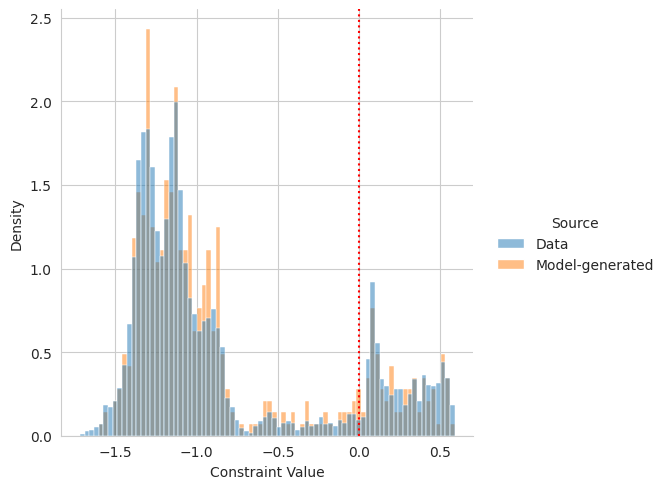

In [13]:
df = pd.concat((
    pd.Series(constraint(ds.Zs[:len(ds) - cfg.dataset.batch_size]), name='Data'),
    pd.Series(constraint(samples), name='Model-generated'),
), axis=1).melt(var_name='Source', value_name='Constraint Value')
plot = sns.displot(
    data=df,
    stat='density',
    x='Constraint Value',
    hue='Source',
    common_norm=False,
    bins=80,
)
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')

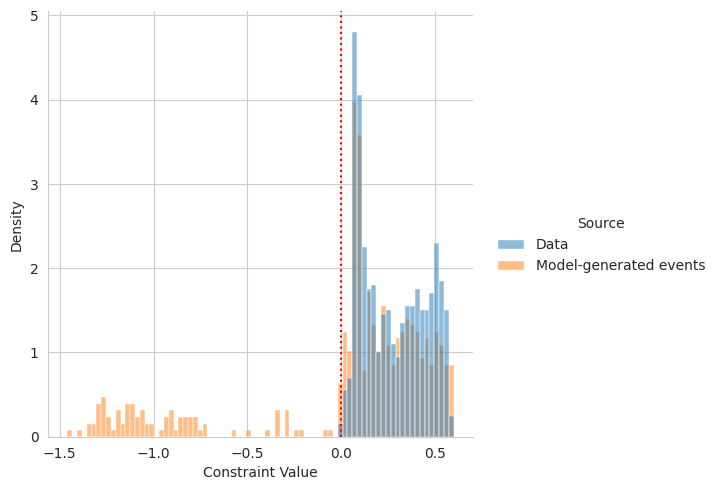

In [14]:
df = pd.concat((
    pd.Series(constraint(
        ds.Zs[:len(ds) - cfg.dataset.batch_size][constraint(ds.Zs[:len(ds) - cfg.dataset.batch_size]) > 0]
    ), name='Data'),
    pd.Series(constraint(event_samples), name='Model-generated events'),
), axis=1).melt(var_name='Source', value_name='Constraint Value')
plot = sns.displot(
    data=df,
    stat='density',
    x='Constraint Value',
    hue='Source',
    common_norm=False,
    bins=80,
)
for (row, col, hue), data in plot.facet_data():
    ax = plot.axes[row][col]
    ax.axvline(x=0, c='r', ls=':')